# Prices

### Source

Market Data Source: 

    Junta de Andalucía (warehouse output prices paid to farmers)

    http://www.juntadeandalucia.es/agriculturaypesca/observatorio/servlet/FrontController?action=Static&subsector=19&url=subsector.jsp

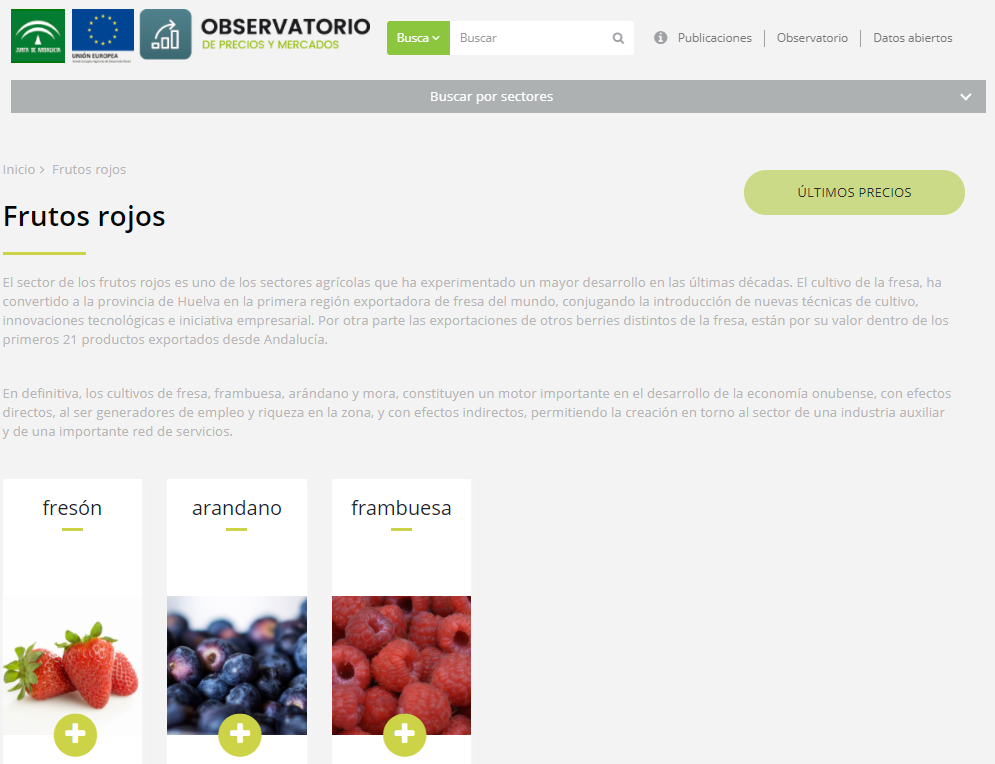

In [6]:
from IPython.display import Image
Image("../../data/01_raw/prices/website_junta.png")

### Import scripts

In [18]:
def get_prices_junta():

    ##  Function to get spanish prices from external files downloaded from official spanish region government website  #

    import pandas as pd
    import datetime
    pd.set_option('display.max_columns',None) ## Display all columns in pandas dataframe  
    pd.set_option('display.max_rows',None) ## Display all rows in pandas dataframe 

    sheet_name = 'Observatorio de Precios'
    rows_skip_13 = [1,2,3,4,5,6,7,8,9,10,11,12,13]
    rows_skip_14 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
    rows_skip_15 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    cols = [0,1]
    file_names_year = [  
                        ['../../data/01_raw/prices/ArandanoPreciosAgricultor.xls',sheet_name,rows_skip_15,cols,'PriceProducer','BLUEBERRIES',0,25],\
                        ['../../data/01_raw/prices/FrambuesaPreciosAgricultor.xls',sheet_name,rows_skip_15,cols,'PriceProducer','RASPBERRIES',35,25],\
                        ['../../data/01_raw/prices/FresaPreciosAgricultor.xls',sheet_name,rows_skip_15,cols,'PriceProducer','STRAWBERRIES',48,22]\
                    ]

    price = pd.DataFrame()
    price = pd.read_excel(file_names_year[0][0]\
                                ,sheet_name = file_names_year[0][1]\
                                ,header = 6\
                                ,skiprows = file_names_year[0][2]\
                                ,usecols = file_names_year[0][3])
    price.columns = ['Week',file_names_year[0][4]]
    price[['Week_No','Year']] = price.Week.str.split(pat='-',expand=True)
    price['Week_No'] = price['Week_No'].astype('int32')
    price['Year'] = price['Year'].astype('int32')
    price.drop_duplicates(inplace=True)
    price['Crop'] = file_names_year[0][5]
    price['Week_Campaign'] = price['Week_No'].apply(lambda x: (x - file_names_year[0][6] + 53) % 53 )
    price['Week_Campaign'] = price['Week_Campaign'].astype('int32')
    price['Year_Campaign'] = price['Week_No'].apply(lambda x : 0 if 0 == file_names_year[0][6] else 0 if x < file_names_year[0][6] else 1)
    price['Year_Campaign'] = price['Year_Campaign'].astype('int32')
    price.to_excel(f'../../data/02_intermediate/Price_Excel{file_names_year[0][5]}.xlsx')
    price['Year_Campaign'] = price['Year_Campaign'] + price['Year']

    for i in range(1,len(file_names_year)):
        price_excel=pd.read_excel(file_names_year[i][0]\
                                ,sheet_name=file_names_year[i][1]\
                                ,header=6\
                                ,skiprows=file_names_year[i][2]\
                                ,usecols=file_names_year[i][3])
        price_excel.columns = ['Week',file_names_year[i][4]]
        price_excel[['Week_No','Year']] = price_excel.Week.str.split(pat='-',expand=True)
        price_excel['Week_No'] = price_excel['Week_No'].astype('int32')
        price_excel['Year'] = price_excel['Year'].astype('int32')
        price_excel.drop_duplicates(inplace=True)
        price_excel['Crop'] = file_names_year[i][5]
        # Common campaign dates:
            # Strawberry campaign from week 49 to 22
            # Blueberry campaign from week 1 to 25
            # Raspberry campaign from week 36 to 25
        price_excel['Week_Campaign'] = price_excel['Week_No'].apply(lambda x: (x - file_names_year[i][6] + 53) % 53 )
        price_excel['Week_Campaign'] = price_excel['Week_Campaign'].astype('int32')
        price_excel['Year_Campaign'] = price_excel['Week_No'].apply(lambda x : 0 if 0 == file_names_year[i][6] else 0 if x < file_names_year[i][6] else 1)
        price_excel['Year_Campaign'] = price_excel['Year_Campaign'].astype('int32')
        price_excel['Year_Campaign'] = price_excel['Year_Campaign'] + price_excel['Year'] 
        price = price.append(price_excel)
        price_excel.to_excel(f'../../data/02_intermediate/Price_Excel{file_names_year[i][5]}.xlsx')
        price_excel[price_excel['Crop']==file_names_year[i][5]].groupby(['Year_Campaign'])['PriceProducer'].describe().transpose().to_excel(f'./../../data/02_intermediate/summary_{file_names_year[i][5]}.xlsx')
            
    price['Date_Ref']=price['Week'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%V-%G-%u') )
    price.drop(range(0,price.PriceProducer.notna().idxmax()),inplace=True)
    price = price [['Crop',\
                    'PriceProducer',\
                    'Week',\
                    'Week_No',\
                    'Year',\
                    'Date_Ref',\
                    'Week_Campaign',\
                    'Year_Campaign']]
    price.dropna(subset=['PriceProducer'], inplace=True)
    price['Country']='ES'
    price['Currency']='EUR'
    price['Measure']='KG'
    price['Region']='ANDALUSIA'
    price['Trade_Country']='ES'
    price['Category']='std'
    price['Package']='bulk'

    return price

In [68]:
def load_prices_bbdd(df_prices):

    ##  Function to upload prices retrieved to SQL Server Database   #

    import pyodbc
    from datetime import datetime
    import pandas as pd

    connStr = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=bipro02\\adminbi;DATABASE=Prices;Trusted_Connection=yes')
    cursor = connStr.cursor()

    qry_max_date = "SELECT max(Date_price) FROM [Prices].[dbo].[prices] where cast([Country] as nvarchar) = cast('ES' as nvarchar)"
    max_date = pd.read_sql(qry_max_date, connStr)
    upd = 0

    try:
        for index,row in df_prices.iterrows():
            if row['Date_Ref'] > max_date.loc[0].values[0]: # Python price line date must be greater than the max date in SQL table
                cursor.execute("INSERT INTO dbo.prices([Product],[Country],[Region],[Trade_Country],[Category],[Package],[Campaign],[Campaign_wk],[Date_price],[Currency],[Measure],[Price],[Updated]) values (?,?,?,?,?,?,?,?,?,?,?,?,?)",row['Crop'],row['Country'],row['Region'],row['Trade_Country'],row['Category'],row['Package'],row['Year_Campaign'],row['Week_Campaign'],row['Date_Ref'],row['Currency'],row['Measure'],row['PriceProducer'],datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
                connStr.commit()
                upd += 1
    except TypeError: # If there price is null no posibility to compare operands
        for index,row in df_prices.iterrows(): # When there are no prices in SQL
            cursor.execute("INSERT INTO dbo.prices([Product],[Country],[Region],[Trade_Country],[Category],[Package],[Campaign],[Campaign_wk],[Date_price],[Currency],[Measure],[Price],[Updated]) values (?,?,?,?,?,?,?,?,?,?,?,?,?)",row['Crop'],row['Country'],row['Region'],row['Trade_Country'],row['Category'],row['Package'],row['Year_Campaign'],row['Week_Campaign'],row['Date_Ref'],row['Currency'],row['Measure'],row['PriceProducer'],datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
            connStr.commit()
            upd += 1
    cursor.close()
    connStr.close()
    print(upd," new prices added")

# Volumes

### Source

Market Data Source: 

    IBO (International Blueberry Association)

    https://www.internationalblueberry.org/

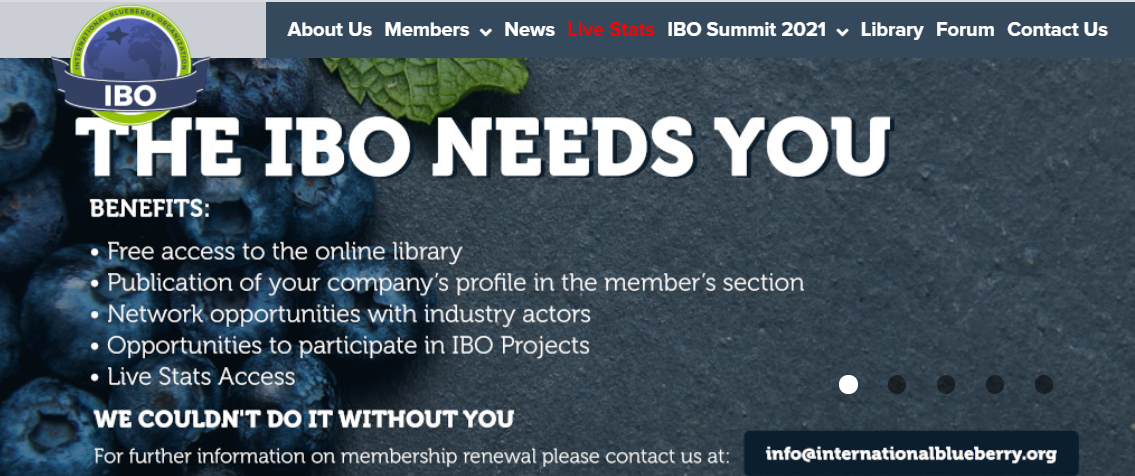

In [21]:
from IPython.display import Image
Image("../../data/01_raw/volumes/website_ibo.png")

### Import scripts

In [4]:
def get_volumes_ibo():

    ##  Function to get UE import volumes from external files downloaded from international blueberry organization website  #

    import os
    import pandas as pd
    import datetime

    directory = '../../data/01_raw/volumes/'
    volume = pd.DataFrame()
    for filename in os.listdir(directory):
        if filename.endswith(".xls"):
            #print(os.path.join(directory, filename))
            curr = pd.DataFrame(pd.read_excel(os.path.join(directory, filename)))
            curr['Filename'] = filename
            volume = volume.append(curr)
        else:
            continue
    volume.drop('Week.1', axis=1, inplace=True)

    # Validation
    df_all = pd.DataFrame(volume[volume.Filename=='BLUEBERRIES-SUM.xls'].agg('sum')).drop(['Week','Filename'])
    df_countries = volume[volume.Filename!='BLUEBERRIES-SUM.xls'].agg('sum').drop(['Week','Filename'])
    if (df_countries.subtract(df_all, fill_value=0).sum()[0] != 0.):
        raise Exception('Volume files unbalanced')

    # Cleanance

    # new data frame with split value columns 
    new = volume.Filename.str.split("-", n = 1, expand = True) 
    # making separate first name column from new data frame 
    volume['Product']= new[0] 
    # making separate last name column from new data frame 
    volume['Trade_country']= new[1].str.rstrip('.xls')
    # Dropping old Name columns 
    volume.drop(columns =['Filename'], inplace = True) 
    # Fill NaNs with 0 values
    volume.fillna(0, inplace=True)
    # Convert columns in rows
    volume = volume.melt(id_vars=['Week','Product','Trade_country'], 
            var_name="Year", 
            value_name="Volume")
    # Drop 'Sum' lines which include all countries groupped
    volume.drop(volume[volume['Trade_country']=='SUM'].index, inplace=True)
    # Set date column
    volume.rename(columns={"Week": "Week_num"}, inplace = True)
    volume['Week_desc'] = volume['Week_num'].astype('str').str.cat(volume['Year'].astype('str'), sep ="-")
    volume['Date_ref'] = volume['Week_desc'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%V-%G-%u') )
    # Add fixed values
    volume['Measure'] = 'KG'
    volume['Country'] = 'EU'
    volume['Region'] = ''
    volume['Trade_Type'] = 'Import'
    volume['Category'] = 'std'
    volume['Package'] = 'std'
    volume['Transport'] = 'na'

    return volume

In [5]:
def load_volumes_bbdd(df_volumes):

    ##  Function to upload prices retrieved to SQL Server Database   #

    import sys
    sys.path.insert(0, '../../src')
    sys.path.append('../../src/d01_data')
    sys.path.append('../../src/d02_processing')
    sys.path.append('../../src/d03_modelling')
    import transformations as transf
    import pyodbc
    from datetime import datetime, timedelta

    connStr = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=bipro02\\adminbi;DATABASE=Prices;Trusted_Connection=yes')
    cursor = connStr.cursor()

    # Delete all data with volumes dates greater than the ndays parameter last days from today
    N = 60 
    rep_date = datetime.now().date() - timedelta(days=N)
    qry_delete = f"DELETE FROM [Prices].[dbo].[volumes] where cast([Country] as nvarchar) = cast('EU' as nvarchar) and Date_volume > '{rep_date}'"
    cursor.execute(qry_delete)

    # Load all data with volumes dates greater than the ndays parameter last days from today
    upd = 0

    try:
        for index,row in df_volumes.iterrows():
            if row['Date_ref'] > rep_date: # Python volumes line date must be greater than the max date in SQL table
                cursor.execute("INSERT INTO dbo.volumes([Product],[Country],[Region],[Trade_Type],[Trade_Country],[Category],[Package],[Transport],[Campaign],[Campaign_wk],[Date_volume],[Measure],[Volume],[Updated]) values (?,?,?,?,?,?,?,?,?,?,?,?,?,?)",row['Product'],row['Country'],row['Region'],row['Trade_Type'],transf.label_trade_countries(row['Trade_country']),row['Category'],row['Package'],row['Transport'],row['Year'],row['Week_num'],row['Date_ref'],row['Measure'],row['Volume'],datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
                connStr.commit()
                upd += 1
    except TypeError: # If there volume is null no posibility to compare operands
        for index,row in df_volumes.iterrows(): # When there are no volumes in SQL
            cursor.execute("INSERT INTO dbo.volumes([Product],[Country],[Region],[Trade_Type],[Trade_Country],[Category],[Package],[Transport],[Campaign],[Campaign_wk],[Date_volume],[Measure],[Volume],[Updated]) values (?,?,?,?,?,?,?,?,?,?,?,?,?,?)",row['Product'],row['Country'],row['Region'],row['Trade_Type'],transf.label_trade_countries(row['Trade_country']),row['Category'],row['Package'],row['Transport'],row['Year'],row['Week_num'],row['Date_ref'],row['Measure'],row['Volume'],datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
            connStr.commit()
            upd += 1
    print(upd," new volumes added")

    cursor.close()
    connStr.close()